In [2]:
# Load libraries

%load_ext autoreload
%autoreload 2
import utils
import img_processing
import cv2
import skimage
import os
import numpy as np
from numpy import asarray
from PIL import Image
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage
plt.rcParams['figure.figsize'] = [10,10]

In [3]:
# Load dataset
dataset_path = r"data/testing"
dataset_dic = utils.load_dataset(dataset_path)

In [4]:
from skimage.filters import threshold_yen, threshold_otsu, threshold_mean

experiment = 'native2'
img_pairs = dataset_dic[experiment]
list_img = []
bg_inten = []
for i,img_pair in enumerate(img_pairs):

        bf_img = img_pair[0]
        dapi_img = img_pair[1]
        thresh=threshold_otsu(img_processing.rgb2gray(dapi_img))
        thresh_img =  img_processing.rgb2gray(dapi_img)<= thresh
        mask_1 = img_processing.invert_mask(thresh_img.astype(int))
        mask_holes=img_processing.closing(mask_1,3,3)
     

        masked_dapi = img_processing.apply_mask2img(dapi_img,mask_holes)
        dapi_intensity_masked, intensity_total, nb_pixels_dapi = img_processing.average_intensity(masked_dapi,1,mask.sum())
        
        print(dapi_intensity_masked)
        utils.im_show(mask_holes)
        


NameError: name 'mask' is not defined

In [36]:
import csv

# ------Parameters:
experiment = 'native2'
blob_1=2000
blob_2=15000

print('Experiment: ', experiment)
file_name = dataset_path[5:] + experiment+'.csv'
with open(file_name, mode='w',newline='') as file:
    file_writer = csv.writer(file, delimiter=',') 
    file_writer.writerow(['image_number','dapi original','final intensity','bg intensity'])
    img_pairs = dataset_dic[experiment]
    list_img = []
    bg_inten = []
    for i,img_pair in enumerate(img_pairs):

        bf_img = img_pair[0]
        dapi_img = img_pair[1]

        #calculate the original intensity of the dapi image before the mask
        dapi_intensity_original, intensity_total, nb_pixels = img_processing.average_intensity(dapi_img,1,dapi_img[:,:,2].size)
        #mask pre processing (gray scale, illumination correction, contrast stretching and normalization)
        bf_gs = img_processing.rgb2gray(bf_img)
        #bf_corr =img_processing.bg_correct(bf_gs)
        bf_eq = img_processing.eq_norm(bf_gs)
        #apply entropy and treshold to create the mask
        mask_1,ent_img= img_processing.entropy_filter(bf_eq)
        #closing
        mask_holes=img_processing.closing(mask_1,3,3)
        #remove holes
        mask_labeled,ncomponents1=img_processing.mask_labeling(img_processing.invert_mask(mask_holes))
        mask_hole_free = img_processing.invert_mask(img_processing.remove_small_blobs(mask_labeled, ncomponents1,blob_1))
        #remove artifacts and noise, reach the final mask
        mask_labeled_2, ncomponents_2 = img_processing.mask_labeling(mask_hole_free) 
        mask=img_processing.remove_small_blobs(mask_labeled_2,ncomponents_2,blob_2)        

        mask_size = mask.sum()
        list_img.append(bf_eq)
        list_img.append(mask)

        #calculate average dapi intensities
        masked_dapi = img_processing.apply_mask2img(dapi_img,mask)
        masked_bg = img_processing.apply_mask2img(dapi_img,img_processing.invert_mask(mask))
        
        dapi_intensity_masked, intensity_total, nb_pixels_dapi = img_processing.average_intensity(masked_dapi,1,mask.sum())
        bg_intensity, intensity_total_bg, nb_pixels_bg = img_processing.average_intensity(masked_bg,2,img_processing.invert_mask(mask).sum())
        if nb_pixels_bg > 0*nb_pixels: #20% of the total number of pixels
            final_avg_intensity = dapi_intensity_masked-bg_intensity
        else:
            final_avg_intensity = dapi_intensity_masked

        print('image n:', i, '| original avg: ',dapi_intensity_original, '| avg NO bg subtraction:',dapi_intensity_masked,'| bg intensity:',bg_intensity)
        out = [i,dapi_intensity_original,final_avg_intensity, bg_intensity]
        file_writer.writerow(out)

Experiment:  native2


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.


image n: 0 | original avg:  4.270633729999998 | avg NO bg subtraction: 6.589278452324287 | bg intensity: 0.88


In [ ]:
utils.im_show(ent_img)

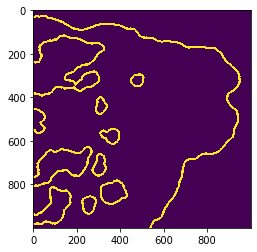

In [10]:
from skimage import filters
from skimage.morphology import disk

contours = filters.sobel(mask)
contours[contours != 0] = 1
kernel_dil=disk(2)
contours_dil= cv2.dilate(contours,kernel_dil,iterations = 2)
utils.im_show(contours_dil)

In [ ]:
alpha = 0.5
beta = 0.5
contours_3 = (np.repeat(contours_dil[:, :, np.newaxis], 3, axis=2)*255).astype(np.uint8)
contours_3[:,:,1:3] = 0
dst = cv2.addWeighted(bf_img, alpha, contours_3, beta, 0.0)
alpha = 0.9
beta = 0.1
mask_invert = mask
mask_invert[mask_invert==1] = 2
mask_invert[mask_invert==0] = 1
mask_invert[mask_invert==2] = 0
mask_3 = (np.repeat(mask[:, :, np.newaxis], 3, axis=2)*255).astype(np.uint8)
mask_3[:,:,1:3] = 0
dst_wmask= cv2.addWeighted(dst, alpha, mask_3 , beta, 0.0)
plt.imshow(dst_wmask)

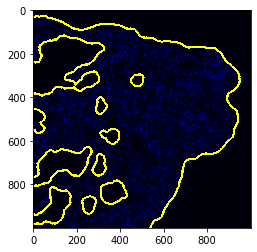

In [11]:
contours[contours != 0] = 1

# Versão simples
contours_3 = (np.repeat(contours_dil[:, :, np.newaxis], 3, axis=2)*255).astype(np.uint8)
contours_3[:,:,2] = 0
bf_img_cp = bf_img.copy()
dapi_img_cp=dapi_img.copy()
bf_img_cp[contours_3==255] = 255
dapi_img_cp[contours_3==255] = 255

plt.figure(1)
plt.imshow(dapi_img_cp)

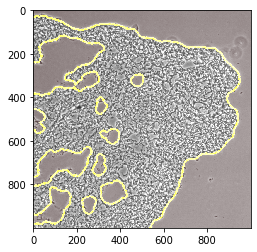

In [12]:
# Versao com mascara 
alpha = 0.9
beta = 1-alpha
mask_invert = mask.copy()
mask_invert[mask_invert==1] = 2
mask_invert[mask_invert==0] = 1
mask_invert[mask_invert==2] = 0
mask_3 = (np.repeat(mask_invert[:, :, np.newaxis], 3, axis=2)*255).astype(np.uint8)
mask_3[:,:,1:3] = 0
dst_wmask= cv2.addWeighted(bf_img_cp, alpha, mask_3 , beta, 0.0)
bf_img_cp2 = bf_img_cp.copy()
bf_img_cp2[mask_3==255] = dst_wmask[mask_3==255]
plt.figure(2)
plt.imshow(bf_img_cp2)

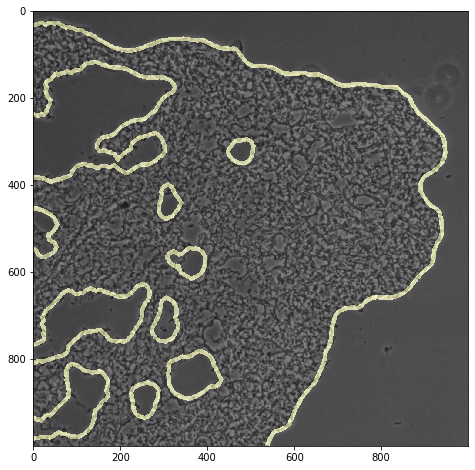

In [13]:
from matplotlib import pyplot as plt

plt.figure(figsize = (8,8))
plt.imshow(contours_dil, cmap='inferno')
plt.imshow(bf_img,alpha=0.5)

In [14]:
from PIL import Image

def convertImage(img1):
    
    img = img1.convert("RGBA")
  
    datas = img.getdata()
  
    newData = []
  
    for items in datas:
        if item[0] == 255 and item[1] == 255 and item[2] == 255:
            newData.append((255, 255, 255, 0))
        else:
            newData.append(item)

In [6]:
convertImage(contours)

NameError: name 'contours' is not defined

In [15]:
dst = cv2.addWeighted(dapi_img, 0.5, bf_img, 0.7, 0)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  


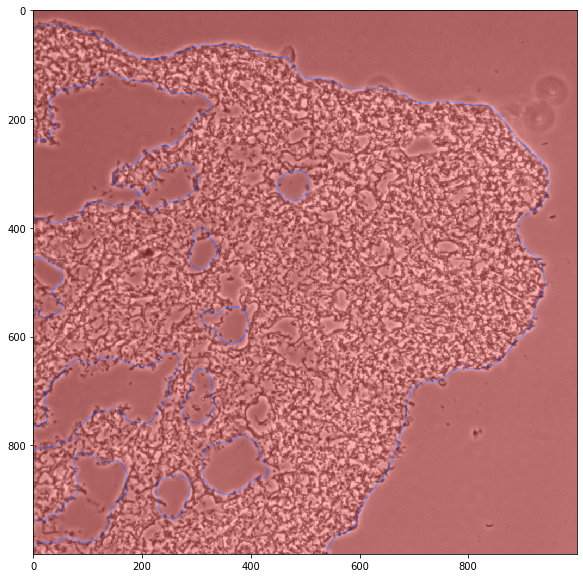

In [16]:
# Let's look at the result
from skimage.measure import label
from skimage.color import label2rgb
# Label regions
#lbls = label(mask)
res = label2rgb(contours, image=bf_img)
# Plot result
fig = plt.figure(figsize=(20, 10))
plt.imshow(res)

## tEST JOAO

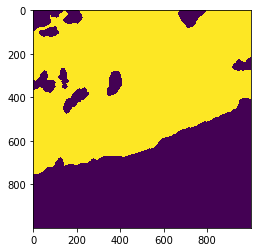

In [37]:
plt.imshow(mask)

In [115]:

dapi_masked_3 = dapi_img.copy()
#dapi_masked_3 = img_processing.rgb2gray(dapi_masked_3)
dapi_masked_3 = dapi_masked_3[:,:,2]

In [116]:
dapi_masked_3 = dapi_masked_3[mask==0]


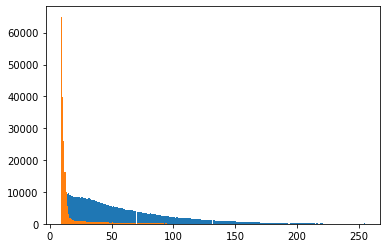

In [118]:
plt.figure(0)
dapi_masked_3 = dapi_img.copy()
#dapi_masked_3 = img_processing.rgb2gray(dapi_masked_3)
dapi_masked_3 = dapi_masked_3[:,:,2]
dapi_masked_3 = dapi_masked_3[mask==1]

n_og, bins_og,_=plt.hist(dapi_masked_3, bins=250)

dapi_masked_3 = dapi_img.copy()
#dapi_masked_3 = img_processing.rgb2gray(dapi_masked_3)
dapi_masked_3 = dapi_masked_3[:,:,2]
dapi_masked_3 = dapi_masked_3[mask==0]
_,_,_=plt.hist(dapi_masked_3, bins=bins_og)

(array([6.5003e+04, 3.9928e+04, 2.5938e+04, 1.6290e+04, 9.9170e+03,
        5.4920e+03, 2.9500e+03, 1.9100e+03, 1.4160e+03, 1.1690e+03,
        1.0870e+03, 9.9100e+02, 9.1900e+02, 8.9200e+02, 8.1100e+02,
        8.3100e+02, 7.8500e+02, 7.4600e+02, 7.5700e+02, 7.6100e+02,
        7.3900e+02, 6.7900e+02, 6.7300e+02, 6.5500e+02, 6.5500e+02,
        6.2200e+02, 6.1900e+02, 6.2100e+02, 5.4400e+02, 5.8700e+02,
        5.3800e+02, 5.2900e+02, 5.0600e+02, 5.2500e+02, 4.9900e+02,
        4.6600e+02, 4.2600e+02, 4.3600e+02, 4.7000e+02, 4.1400e+02,
        3.8300e+02, 3.6700e+02, 4.1800e+02, 3.4500e+02, 3.6800e+02,
        3.1700e+02, 2.9900e+02, 2.7700e+02, 2.9400e+02, 2.8000e+02,
        2.7600e+02, 2.7400e+02, 2.2200e+02, 2.4400e+02, 2.4100e+02,
        2.1500e+02, 2.2500e+02, 2.2700e+02, 1.9200e+02, 1.8600e+02,
        1.8400e+02, 2.0900e+02, 0.0000e+00, 1.9800e+02, 1.7600e+02,
        1.9100e+02, 1.4800e+02, 1.4200e+02, 1.4000e+02, 1.6400e+02,
        1.3500e+02, 1.4600e+02, 1.3800e+02, 1.34

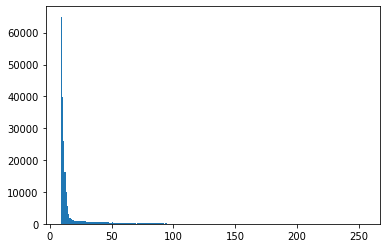

In [117]:
plt.hist(dapi_masked_3, bins=bins_og)

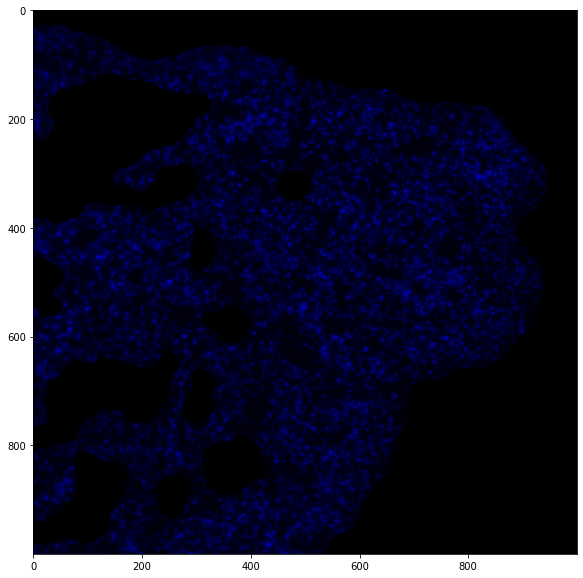

In [187]:
plt.imshow(dapi_masked)

(array([2.408539e+06, 0.000000e+00, 0.000000e+00, 1.300000e+01,
        9.279000e+03, 2.865200e+04, 3.585700e+04, 5.185900e+04,
        3.257100e+04, 4.554300e+04, 2.787100e+04, 2.624200e+04,
        3.595700e+04, 2.178100e+04, 2.946700e+04, 1.794700e+04,
        1.652200e+04, 2.261900e+04, 1.350400e+04, 1.888000e+04,
        1.158200e+04, 1.559300e+04, 9.573000e+03, 8.873000e+03,
        1.220600e+04, 7.430000e+03, 1.043500e+04, 6.306000e+03,
        5.712000e+03, 8.045000e+03, 4.950000e+03, 6.592000e+03,
        4.114000e+03, 3.807000e+03, 5.060000e+03, 3.090000e+03,
        4.268000e+03, 2.416000e+03, 2.257000e+03, 3.103000e+03,
        1.861000e+03, 2.550000e+03, 1.463000e+03, 2.055000e+03,
        1.236000e+03, 1.118000e+03, 1.500000e+03, 9.140000e+02,
        1.115000e+03, 7.030000e+02, 6.690000e+02, 8.660000e+02,
        4.870000e+02, 7.400000e+02, 4.220000e+02, 3.460000e+02,
        4.840000e+02, 2.960000e+02, 3.870000e+02, 2.440000e+02,
        3.190000e+02, 1.830000e+02, 1.50

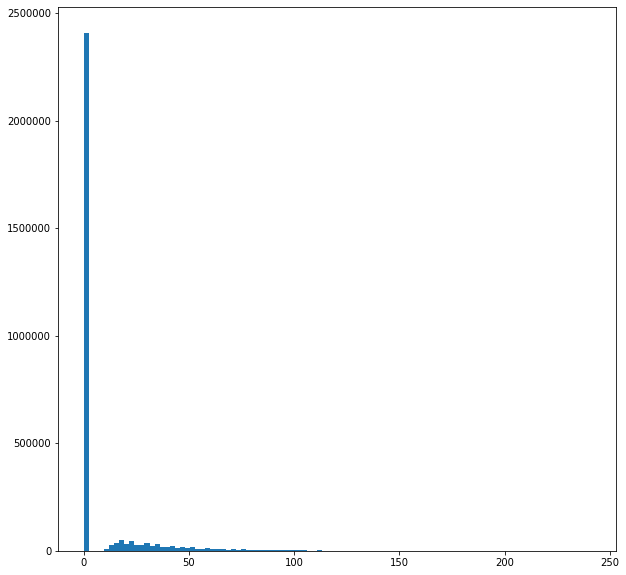

In [186]:
plt.hist(dapi_masked.flatten(), bins=100)